### This will be in the prepare module
    _Check for and remove duplicates by customer_id. - None
    
    _Remove redundant columns: payment_type_id, internet_service_type_id, contract_type_id, & customer_id. - Completed
        -Used the following to drop redundant columns
        -df = df.drop(['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], axis = 1)
        -df.head(2)
    
    _Encode payment_type(Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)), internet_service_type(DSL, Fiber, None), contract_type(Month-to-month, One year, Two year), gender(male/female), partner(yes/no), multiple_line(yes/no), device_protection(yes/no), tech_support(yes/no), streaming_tv(yes/no), streaming_movies(yes/no), paperless_billing, & churn (yes/no).
    - gender is male(1) or not male(0)
    - yes(1) no(0)
    - payment, contract and service types (True = 1) (Fales = 0)
    
    _Check for nulls and fill (Fill in total_charges' blanks with 0). - Completed
        -#find empty values. Tried isna, isnull, notna, notnull but did not shown any matches.
            -df.eq(' ').sum()
        -Used .replace to empty values with a 0 in total charges.
            -df = df.replace({'total_charges': ' '}, 0)
            -df.head()

    _Convert total_charges to float64. - Completed
        -#convert 'total_charges' to float and validate change.
        - df['total_charges'] = df['total_charges'].astype(float)
        - df.dtypes
    
    _Replace 'No phone service' & 'No internet service' with 'No'. - Completed
        -df.replace(to_replace = 'No internet service', value = 'No')
        -df.replace(to_replace = 'No phone service', value = 'No')

In [1]:
#libraries
import get_db
import explore
import prepare
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import graphviz
from graphviz import Graph

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Plan

    Goal: Identify feature(s) that cause the greatest churn.
    
    Taking you through the data pipeline I will begin with acquiring the telcor data from the get_db.py module, prepare it using the prepare.py module, split the data and on through exploration. Using explore.py module I identified a set of features used to develop my initial hypothesis. Once cleaned I ran it through multivariate to compare features to help with testing the listed inital hypothesis. Each exploration will include takeaways that have led to preparing, cleaning ant testing of the data resulting in rejecting or failing to reject the final hypothesis.
    
    Features within my hypothesis have been split, tested and modeled in order to provide a recommendation on the final hypothesis in order to reduce churn rates based rejected or failed to reject of the hypothesis. 
    
    I have also identified unknown variables that at a later time can be researched, developed and tested using this model to predict future churn.

    My initial hypothesis are listed below:
    
        1. Customers on fiber are more likely to churn than those customers not on fiber.
            - Null:
            - Alternate:
        2. Customers are more than likely to churn in the first month of service than any other customer.
            - Null:
            - Alternate:
        3. Customers who are NOT senior citizens are more likely to churn than senior citizens.
            - Null:
            - Alternate:
        4. m2m churn is greater than those customers not on m2m plan.
            - Null:
            - Alternate:
        5. Customers enrolled in automatic payment plan are less likely to churn than those customers not enrolled in the automatic payment plan.
            - Null:
            - Alternate:
        6. Customers with phone_service (951) are more likely to churn than those that do not have phone_service?
            - Null:
            - Alternate:
            
    FEATURES:
    
        *** fiber (YES), tenure (1 month), single (NO), senior citizen (NO), m2m (YES), autopayments (NO), phone_service (YES)

    FINAL HYPOTHESIS (reject or fail to reject):

        *** Customers who are young, not single, on fiber, has phone service, on m2m, and not enrolled in a autopayment plan are more likely to churn than those customers that do not fall in this category.
        

    Exploration:
        1. Univariate
        2. Bivariate
        3. Multivariate

    Modeling:
        1. Decision Tree
        2. Random Forrest
        3. KNN
        
    Conclusion
        In conclusion, we ran through the data pipeline, identified our initial hypothesis, split, tested and model our features that resulted in the following recommendations.
        1.
        2.
        3.


# Working code for project

# Acquire

In [2]:
df = get_db.get_telco_data()
df.head(1)

,payment_type_id,payment_type,internet_service_type_id,internet_service_type,contract_type_id,contract_type,customer_id,gender,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,1,Electronic check,1,DSL,1,Month-to-month,0015-UOCOJ,Female,1,No,...,Yes,No,No,No,No,No,Yes,48.2,340.35,No


In [ ]:
#data summarization
df.describe(include='all').T

In [ ]:
df.info()

#### Initial visualization

In [ ]:
#plot charts on acquired data prior to data cleaning.
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [ ]:
#value counts on acquired data prior to data cleaning.
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

#### From above:
    - From above plot charts and column value counts we find the following have no weight on churn rate and will be dropped:
        - Remove 'phone_service', 'internet_service', 'senior_citizen', 'paperless' & 'tech_support' (irrelevant)

# Clean

In [3]:
#added above to the prepare module.
df = prepare.clean_data(df)
df.head()

,tenure,monthly_charges,total_charges,bank_transfer,credit_card,e_check,check,dsl,fiber,no_internet,...,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless
0,7,48.20,340.35,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
1,1,25.10,25.10,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,49.25,91.10,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
3,64,81.25,5567.55,0,0,1,0,1,0,0,...,0,1,1,1,1,1,1,1,0,0
4,6,50.35,314.55,0,0,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tenure             7043 non-null   int64  
 1   monthly_charges    7043 non-null   float64
 2   total_charges      7043 non-null   float64
 3   bank_transfer      7043 non-null   uint8  
 4   credit_card        7043 non-null   uint8  
 5   e_check            7043 non-null   uint8  
 6   check              7043 non-null   uint8  
 7   dsl                7043 non-null   uint8  
 8   fiber              7043 non-null   uint8  
 9   no_internet        7043 non-null   uint8  
 10  m2m                7043 non-null   uint8  
 11  one_year_contract  7043 non-null   uint8  
 12  two_year_contract  7043 non-null   uint8  
 13  senior_citizen     7043 non-null   int64  
 14  churned            7043 non-null   uint8  
 15  is_male            7043 non-null   uint8  
 16  partner            7043 

# Split your data into train, validate, and test samples.

    The resulting dataframes should be 3 samples:
    
        1. a dataframe for training the algorithms
            * The train dataset is for training our models. We also perform our exploratory data analysis on train.
            
        2. a dataframe for validating the models developed on unseen data
            *First, it is an "out of sample" dataset so that we can evaluate our models on unseen data to measure how well the model generalizes.
            *Second, the validate set allows us to fine tune our hyperparameters.
            
        3. a dataframe for testing the best performing model to ensure the model is able to be generalized on a final set of unseen data not 'overfitting' train, a validate and a test, roughly a 70%:20%:10% split
            *final out of sample dataset used to evaluate how well the models tuned on validate generalize on unseen data.

In [5]:
#Split the data

train, validate, test = prepare.train_validate_test_split(df, 'churned')
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3943, 27)
validate -> (1691, 27)
test -> (1409, 27)


In [6]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train.drop(columns=["churned"])
y_train = train.churned

X_validate = validate.drop(columns=["churned"])
y_validate = validate.churned

X_test = test.drop(columns=["churned"])
y_test = test.churned

In [ ]:
# create X & y version of train, where y is a series with just the target variable and X are all the features.
X_train = train[['fiber','auto_payment']]#features
y_train = train.churned#target

X_validate = validate[['fiber','auto_payment']]
y_validate = validate.churned

X_test = test[['fiber','auto_payment']]
y_test = test.churned

In [ ]:
#Now create the model
model1 = DecisionTreeClassifier(max_depth=3, random_state=123)
#Fit the model
model1.fit(X_train, y_train)
#Use the model
y_predictions = model1.predict(X_train)
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(model1.score(X_train, y_train)))

In [ ]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

# Exploratory

    1. Discover features, using  that have the largest impact on the target variable, i.e. provide the most information gain, drive the outcome. To discover patterns, to spot anomalies, to test hypotheses and to check assumptions
        *The dataframe resulting from these functions should be one that is pre-processed, i.e. ready to be used in modeling.
        *attributes are reduced to features, features are in a numeric form, there are no missing values, and continuous and/or ordered values are scaled to be unitless.
        
    2. Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable).
    
    3. Use visualization techniques to identify drivers and follow up with a statistical test, do so.
    
    4. Test Hypothesis (t-tests, correlation, chi-square, e.g.)

#### Univariate Stats

    1. Descriptive stats, frequencies, histograms. Done during prep and prior to splitting.
    
        * Explore the target variable.

        * Explore the categorical/qualitative variables.

        * Explore the continuous/quantitative variables.

In [11]:
cat_vars = ['churned','tenure', 'dsl', 'fiber', 'no_internet', 'm2m', 'partner', 'dependents',
            'phone_service', 'tech_support', 'bank_transfer',
           'credit_card', 'e_check', 'check','one_year_contract','two_year_contract',
           'online_security','online_backup','is_male','multiple_lines','device_protection',
           'streaming_tv','streaming_movies','senior_citizen']#'auto_payment',
quant_vars = ['monthly_charges', 'total_charges']

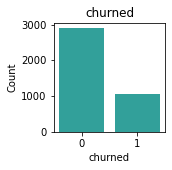

   churned  Count  Percent
0        0   2897    73.47
1        1   1046    26.53
_________________________________________________________________


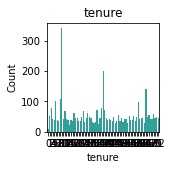

    tenure  Count  Percent
1        9    341     8.65
72      36    201     5.10
2       64    141     3.58
3        8    108     2.74
4        5    102     2.59
..     ...    ...      ...
31      30     29     0.74
59      63     28     0.71
36      33     26     0.66
44      14     24     0.61
0        0      8     0.20

[73 rows x 3 columns]
_________________________________________________________________


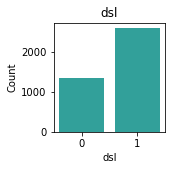

   dsl  Count  Percent
0    1   2592    65.74
1    0   1351    34.26
_________________________________________________________________


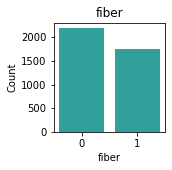

   fiber  Count  Percent
0      0   2191    55.57
1      1   1752    44.43
_________________________________________________________________


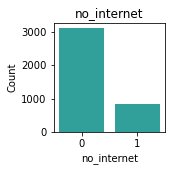

   no_internet  Count  Percent
0            0   3103     78.7
1            1    840     21.3
_________________________________________________________________


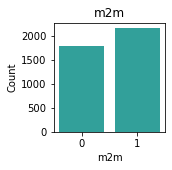

   m2m  Count  Percent
1    1   2160    54.78
0    0   1783    45.22
_________________________________________________________________


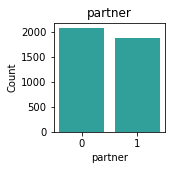

   partner  Count  Percent
0        0   2066     52.4
1        1   1877     47.6
_________________________________________________________________


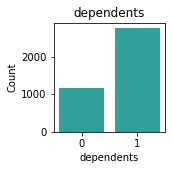

   dependents  Count  Percent
0           1   2763    70.07
1           0   1180    29.93
_________________________________________________________________


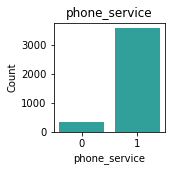

   phone_service  Count  Percent
1              1   3584     90.9
0              0    359      9.1
_________________________________________________________________


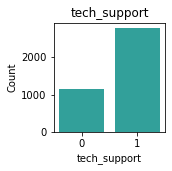

   tech_support  Count  Percent
0             1   2779    70.48
1             0   1164    29.52
_________________________________________________________________


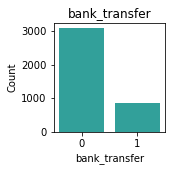

   bank_transfer  Count  Percent
0              0   3083    78.19
1              1    860    21.81
_________________________________________________________________


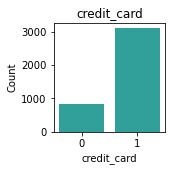

   credit_card  Count  Percent
0            1   3100    78.62
1            0    843    21.38
_________________________________________________________________


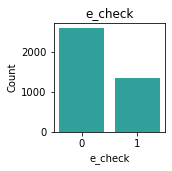

   e_check  Count  Percent
0        0   2586    65.58
1        1   1357    34.42
_________________________________________________________________


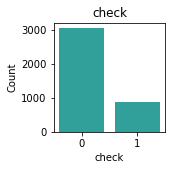

   check  Count  Percent
0      0   3060    77.61
1      1    883    22.39
_________________________________________________________________


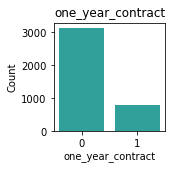

   one_year_contract  Count  Percent
0                  0   3132    79.43
1                  1    811    20.57
_________________________________________________________________


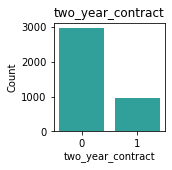

   two_year_contract  Count  Percent
0                  0   2971    75.35
1                  1    972    24.65
_________________________________________________________________


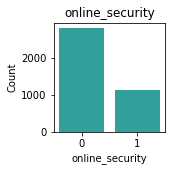

   online_security  Count  Percent
0                0   2812    71.32
1                1   1131    28.68
_________________________________________________________________


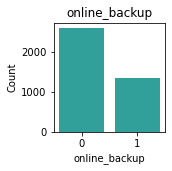

   online_backup  Count  Percent
0              0   2600    65.94
1              1   1343    34.06
_________________________________________________________________


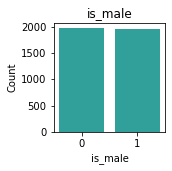

   is_male  Count  Percent
1        0   1973    50.04
0        1   1970    49.96
_________________________________________________________________


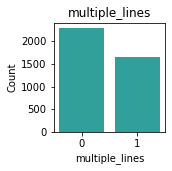

   multiple_lines  Count  Percent
0               0   2286    57.98
1               1   1657    42.02
_________________________________________________________________


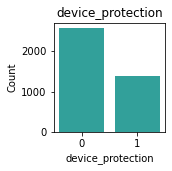

   device_protection  Count  Percent
0                  0   2568    65.13
1                  1   1375    34.87
_________________________________________________________________


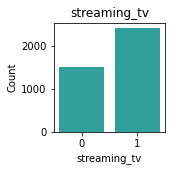

   streaming_tv  Count  Percent
0             1   2423    61.45
1             0   1520    38.55
_________________________________________________________________


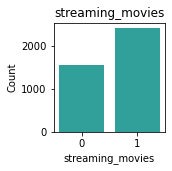

   streaming_movies  Count  Percent
0                 1   2402    60.92
1                 0   1541    39.08
_________________________________________________________________


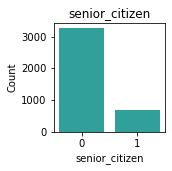

   senior_citizen  Count  Percent
0               0   3261     82.7
1               1    682     17.3
_________________________________________________________________


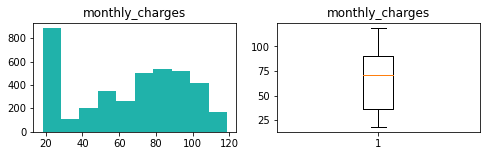

count    3943.000000
mean       65.150710
std        30.030427
min        18.250000
25%        36.475000
50%        70.700000
75%        89.950000
max       118.750000
Name: monthly_charges, dtype: float64


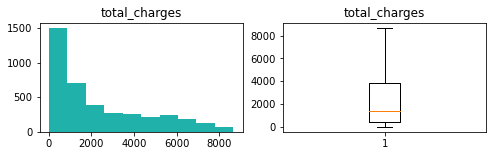

count    3943.000000
mean     2287.059422
std      2272.515282
min         0.000000
25%       393.050000
50%      1386.900000
75%      3810.675000
max      8672.450000
Name: total_charges, dtype: float64


In [12]:
explore.explore_univariate(train, cat_vars, quant_vars)

##### TAKEAWAYS
    8/28/2021

    - 26.53 (1046) customers churned
    - 54.78 (2160) customers are m2m 
    - Customers with a 'partner' similarly divided (47.6 & 52.6 respectively)
    - Customers with 'dependents' account for 70.1%
    - Customers with 'phone_service_ account for 91%
    - m2m - 2160 or 55%, 1 year - 811 or 21%, 2 year - 972 or 24%
    - payment type - convert to autopayment and drop 'check' and 'e_check'
    - gender - convert to 'is_male' and drop female
    
________________________________________-



    _Dropped 'gender' almost an equal amout of male and female which will not effect churn rate
    
    _Dropped 'online_security', 'device_protection' - small amount of customers use these services.
    
    _Seems like a large amount of people use 'tech_support' - Is churn rate affected by bad service.
    _Large number of customers use streaming services.
    
    

#### Bivariate Stats

    1. Plot the interaction of each variable with the target. 
    
    2. Document takeaways.

    3. Explore interation of independent variables using viz and/or hypothesis testing to address interdependence.

In [13]:
cat_vars = cat_vars[1:]

tenure 
_____________________

         chi2       p-value  degrees of freedom
0  673.448746  1.779664e-98                  72

observed:
 churned     0     1   All
tenure                   
0           8     0     8
1         128   213   341
2          61    80   141
3          54    54   108
4          50    52   102
...       ...   ...   ...
69         42     2    44
70         57     5    62
71         96     3    99
72        197     4   201
All      2897  1046  3943

[74 rows x 3 columns]

expected:
              0          1
0     5.877758   2.122242
1   250.539437  90.460563
2   103.595486  37.404514
3    79.349734  28.650266
4    74.941415  27.058585
..         ...        ...
68   38.205427  13.794573
69   32.327669  11.672331
70   45.552625  16.447375
71   72.737256  26.262744
72  147.678671  53.321329

[73 rows x 2 columns]


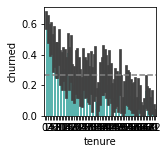


_____________________

dsl 
_____________________

        chi2       p-value  degrees of freedom
0  58.808096  1.738246e-14                   1

observed:
 churned     0     1   All
dsl                      
0        1803   789  2592
1        1094   257  1351
All      2897  1046  3943

expected:
              0           1
0  1904.393609  687.606391
1   992.606391  358.393609


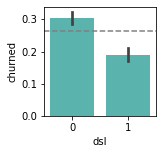


_____________________

fiber 
_____________________

         chi2       p-value  degrees of freedom
0  363.780774  4.230027e-81                   1

observed:
 churned     0     1   All
fiber                    
0        1873   318  2191
1        1024   728  1752
All      2897  1046  3943

expected:
              0           1
0  1609.770987  581.229013
1  1287.229013  464.770987


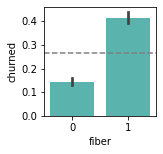


_____________________

no_internet 
_____________________

         chi2       p-value  degrees of freedom
0  202.021901  7.561684e-46                   1

observed:
 churned         0     1   All
no_internet                  
0            2118   985  3103
1             779    61   840
All          2897  1046  3943

expected:
              0           1
0  2279.835405  823.164595
1   617.164595  222.835405


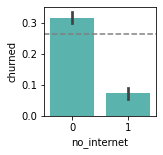


_____________________

m2m 
_____________________

         chi2        p-value  degrees of freedom
0  663.836694  2.187516e-146                   1

observed:
 churned     0     1   All
m2m                      
0        1666   117  1783
1        1231   929  2160
All      2897  1046  3943

expected:
              0           1
0  1310.005326  472.994674
1  1586.994674  573.005326


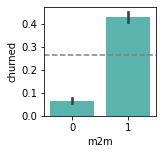


_____________________

partner 
_____________________

        chi2       p-value  degrees of freedom
0  99.970619  1.546747e-23                   1

observed:
 churned     0     1   All
partner                  
0        1379   687  2066
1        1518   359  1877
All      2897  1046  3943

expected:
              0           1
0  1517.931017  548.068983
1  1379.068983  497.931017


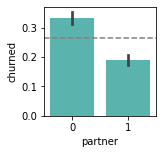


_____________________

dependents 
_____________________

         chi2       p-value  degrees of freedom
0  104.107639  1.916180e-24                   1

observed:
 churned        0     1   All
dependents                  
0           1900   863  2763
1            997   183  1180
All         2897  1046  3943

expected:
              0           1
0  2030.030687  732.969313
1   866.969313  313.030687


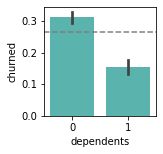


_____________________

phone_service 
_____________________

       chi2   p-value  degrees of freedom
0  0.001099  0.973553                   1

observed:
 churned           0     1   All
phone_service                  
0               264    95   359
1              2633   951  3584
All            2897  1046  3943

expected:
              0           1
0   263.764393   95.235607
1  2633.235607  950.764393


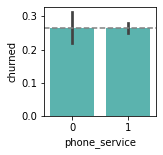


_____________________

tech_support 
_____________________

        chi2       p-value  degrees of freedom
0  96.606082  8.458805e-23                   1

observed:
 churned          0     1   All
tech_support                  
0             1917   862  2779
1              980   184  1164
All           2897  1046  3943

expected:
              0           1
0  2041.786203  737.213797
1   855.213797  308.786203


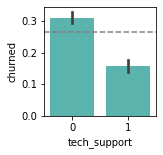


_____________________

bank_transfer 
_____________________

        chi2       p-value  degrees of freedom
0  72.743249  1.476625e-17                   1

observed:
 churned           0     1   All
bank_transfer                  
0              2167   916  3083
1               730   130   860
All            2897  1046  3943

expected:
              0           1
0  2265.141009  817.858991
1   631.858991  228.141009


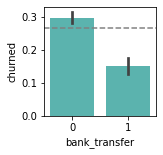


_____________________

credit_card 
_____________________

        chi2       p-value  degrees of freedom
0  58.770411  1.771859e-14                   1

observed:
 churned         0     1   All
credit_card                  
0            2190   910  3100
1             707   136   843
All          2897  1046  3943

expected:
              0           1
0  2277.631245  822.368755
1   619.368755  223.631245


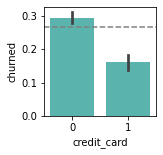


_____________________

e_check 
_____________________

         chi2       p-value  degrees of freedom
0  341.855195  2.516781e-76                   1

observed:
 churned     0     1   All
e_check                  
0        2144   442  2586
1         753   604  1357
All      2897  1046  3943

expected:
             0          1
0  1899.98529  686.01471
1   997.01471  359.98529


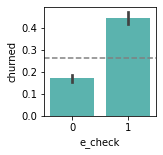


_____________________

check 
_____________________

        chi2       p-value  degrees of freedom
0  24.963674  5.842070e-07                   1

observed:
 churned     0     1   All
check                    
0        2190   870  3060
1         707   176   883
All      2897  1046  3943

expected:
              0           1
0  2248.242455  811.757545
1   648.757545  234.242455


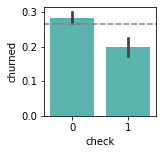


_____________________

one_year_contract 
_____________________

         chi2       p-value  degrees of freedom
0  121.756326  2.610042e-28                   1

observed:
 churned               0     1   All
one_year_contract                  
0                  2177   955  3132
1                   720    91   811
All                2897  1046  3943

expected:
              0           1
0  2301.142277  830.857723
1   595.857723  215.142277


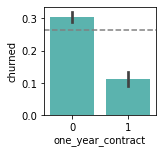


_____________________

two_year_contract 
_____________________

         chi2       p-value  degrees of freedom
0  374.955079  1.560770e-83                   1

observed:
 churned               0     1   All
two_year_contract                  
0                  1951  1020  2971
1                   946    26   972
All                2897  1046  3943

expected:
              0           1
0  2182.852397  788.147603
1   714.147603  257.852397


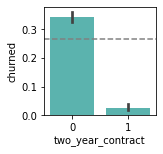


_____________________

online_security 
_____________________

         chi2       p-value  degrees of freedom
0  132.877053  9.618794e-31                   1

observed:
 churned             0     1   All
online_security                  
0                1921   891  2812
1                 976   155  1131
All              2897  1046  3943

expected:
              0           1
0  2066.031955  745.968045
1   830.968045  300.031955


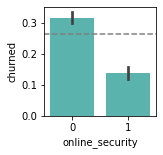


_____________________

online_backup 
_____________________

        chi2       p-value  degrees of freedom
0  33.262971  8.050100e-09                   1

observed:
 churned           0     1   All
online_backup                  
0              1834   766  2600
1              1063   280  1343
All            2897  1046  3943

expected:
              0           1
0  1910.271367  689.728633
1   986.728633  356.271367


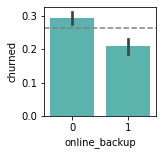


_____________________

is_male 
_____________________

       chi2   p-value  degrees of freedom
0  0.006322  0.936628                   1

observed:
 churned     0     1   All
is_male                  
0        1449   521  1970
1        1448   525  1973
All      2897  1046  3943

expected:
             0          1
0  1447.39792  522.60208
1  1449.60208  523.39792


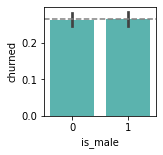


_____________________

multiple_lines 
_____________________

       chi2   p-value  degrees of freedom
0  1.717089  0.190068                   1

observed:
 churned            0     1   All
multiple_lines                  
0               1698   588  2286
1               1199   458  1657
All             2897  1046  3943

expected:
              0           1
0  1679.569363  606.430637
1  1217.430637  439.569363


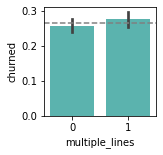


_____________________

device_protection 
_____________________

        chi2       p-value  degrees of freedom
0  26.695574  2.381665e-07                   1

observed:
 churned               0     1   All
device_protection                  
0                  1818   750  2568
1                  1079   296  1375
All                2897  1046  3943

expected:
              0           1
0  1886.760335  681.239665
1  1010.239665  364.760335


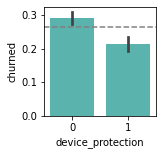


_____________________

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  10.767162  0.001033                   1

observed:
 churned          0     1   All
streaming_tv                  
0             1825   598  2423
1             1072   448  1520
All           2897  1046  3943

expected:
             0          1
0  1780.22597  642.77403
1  1116.77403  403.22597


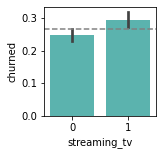


_____________________

streaming_movies 
_____________________

        chi2   p-value  degrees of freedom
0  11.416071  0.000728                   1

observed:
 churned              0     1   All
streaming_movies                  
0                 1811   591  2402
1                 1086   455  1541
All               2897  1046  3943

expected:
              0           1
0  1764.796855  637.203145
1  1132.203145  408.796855


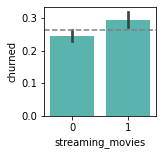


_____________________

senior_citizen 
_____________________

        chi2       p-value  degrees of freedom
0  90.198518  2.154234e-21                   1

observed:
 churned            0     1   All
senior_citizen                  
0               2496   765  3261
1                401   281   682
All             2897  1046  3943

expected:
              0           1
0  2395.921126  865.078874
1   501.078874  180.921126


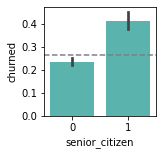


_____________________

monthly_charges 
____________________



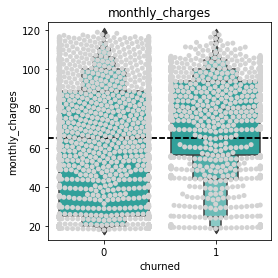

          count       mean        std    min      25%    50%    75%     max
churned                                                                    
0        2897.0  61.850846  31.160324  18.25  25.2000  65.25  89.10  118.75
1        1046.0  74.290010  24.439527  18.95  56.3125  79.55  93.85  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1176266.5, pvalue=6.775715811014378e-27)

____________________

total_charges 
____________________



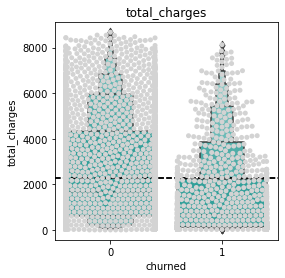

          count         mean          std    min     25%      50%      75%  \
churned                                                                      
0        2897.0  2582.246686  2340.647132   0.00  605.25  1682.05  4326.80   
1        1046.0  1469.509226  1840.557584  19.25  124.25   661.95  2235.65   

             max  
churned           
0        8672.45  
1        8127.60   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2008422.0, pvalue=4.4820761482106014e-55)

____________________



In [14]:
explore.explore_bivariate(train, 'churned', cat_vars, quant_vars)

##### TAKEAWAYS
    8/28/2021

    - Number of fiber (728)  customers who churned.
       * what is about our fiber internet service is making customers churn?
       * Less people churn on DSL (257) then on fiber...possible validation that fiber service needs work.
       * DROP no_internet. Only 61 customers who do not have internet churn.
       HYPOTHESIS: Customers on fiber are more likely to churn than those customers not on fiber. ****convert Fiber and DSL into one column - Fiber(Yes or No) and encode.
       * The new Fiber becomes a feature
       * test hyp

    - 90.5% of customers in the first month churn than any other month
        HYPOTHESIS: Customers are more than likely to churn in the first month of service than any other customer.
        
    - Between 'partner' and 'dependents' less single (no_d_863-no_p_687=176) customers churn then not single people (p_359 + d_183 = 542).
    
    - senior_citizen:
        HYPOTHESIS: Customers who are NOT senior citizens are more likely to churn than senior citizens.
    
    - Contract type:
        * combine  m2m, 1, and 2 year contracts to a single column titled 'm2m' and encode.
        HYPOTHESIS: m2m churn is greater than those customers not on m2m plan.
        
    - Payment type:
        * convert 'bank_transfer' and 'credit_card' payment into autopayment and DROP 'check' and 'e_chek'
        HYPOTHESIS: Customers enrolled in automatic payment plan are less likely to churn than those customers not enrolled in the automatic payment plan.

    - DROP 'is_male' - it is a 50/50 split
    - DROP 'multiple_lines' similar in churn and not churn
    
    - Phone service:
        HYPOTHESIS: Customers with phone_service (951) are more likely to churn than those that do not have phone_service?
        
    - DROP online_security, online_backup, tech_support and device_protection.

----------------------------------------------
    QUESTIONS:
        1. Why do customers on fiber churn more?
        2. Why do customers churn more in the first month than any other month?
        3. Why do non single customers (with partner or dependents) churn more then single customers?
        4. Why do younger customers churn more than older customers?
        5. Why do customers on m2m plans churn more than those customers on contracts?
        6. Why do customers enrolled in autopayments churn less than those customers not enrolled in an autopayment?
        7. Why do customers churn more with phone services?
        
        * What do these questions all have in common?
       ** What is the cost per month of a younger customers who is not single, has phone services and fiber, on a m2m plan, enrolled in an autopayment plan?
       
       *** FINAL HYPOTHESIS: Customers who are young, not single, on fiber, has phone service, on m2m, and not enrolled in a autopayment plan are more likely to churn than those customers that do not fall in this category.
        
        MY FEATURES: fiber (YES), tenure (1 month), single (NO), senior citizen (NO), m2m (YES), autopayments (NO), phone_service (YES)
        
        Test and validate HYPOTHESIS(reject or fail to reject final hypothesis)
_________________________________________________



    _Churn in one month (213)_
        * Incentive...
            - 1 month free service for m2m customers?
            - Free upgrade service for signing a one_year contract?
            - Free premium service for two year contract?
        * Create a graph that shows churn over tenure.
   
   
    _DROPPED one and two year contract. Numbers have no variance on churn.
    _DROPPED 'multiple_lines' has the similar weight which will not affect churn.
    _Validates drops 'online_security', 'device_protection'
    _DROPPED 'total_charges'. total charges for churn are lower than those who did not churn.
    
    _No partner (687) churn more then couples
    _No dependents (863) churn more than people with dependents.
        * Do singles have an affect on churn? If so, why?
    
    _Lose customers in the first year.
       
       
       
    _Higher number of m2m (929) customers churn.
    
    _Those with phone_service (951) churn.
    
    
    _Customers who do not use 'tech_support' (862) tend to churn.
        * Three options:
            1. Drop column 
            2. Or, keep and recommend to market availability of tech support to customers...
            3. Or is tech support the problem? If so, does tech support need more training.
    
    
    _Customers who are not on auto_payment (780) churn.
    
    _Higher monthly cost have a higher tendency to churn and pay an averge of 74.3 than those who do not 61.85.. Does  higher monthly cost affect churn?
    
    _DROP streaming services. Numbers do not show enough to sway a decision.

#### Multivariate Stats

    1. How subgroups compare to each-other and to the overall population. 
    
    2. Answer questions using visualizations and/or hypothesis testing.
    
    (Here I can test some of my questions...reference Exploratory Analysis

    _ Need to drop some columns for the multivariate stats.

In [ ]:
target = 'churned'
explore.explore_multivariate(train, target, cat_vars, quant_vars)

##### TAKEAWAYS

# Modeling

### Decision Tree

In [ ]:
#create the model

#for classification you can change the algorithm to gini or entropy (information gain).  
#Default is gini.

model = DecisionTreeClassifier(max_depth=1, random_state=123)

In [ ]:
#Fit the model

model = model.fit(X_train, y_train)

#### Make predictions

In [ ]:
#Use the model

# We'll evaluate the model's performance on train, first

y_predictions = model.predict(X_train)
y_predictions = [0:5]

#### Estimate probability

In [ ]:
y_pred_proba = model.predict_proba(X_train)
y_pred_proba[0:5]

#### Compute accuracy

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(model.score(X_train, y_train)))

#### Confusion matrix

TP
TN
FP
FN

In [ ]:
confusion_matrix(y_train, y_pred)

In [ ]:
y_train.value_counts()

In [ ]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)


In [ ]:
print(classification_report(y_train, y_pred))

#### Evaluate the Model with our Validate dataset

In [ ]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

In [ ]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = model.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

In [ ]:
# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

### Random Forrest

In [ ]:
#Create the Model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [ ]:
#Fit the Model
rf.fit(X_train, y_train)

In [ ]:
#Use the Model
#evaluate the weight
print(rf.feature_importances_)

In [ ]:
#estimate
y_pred = rf.predict(X_train)

In [ ]:
#probability
y_pred_proba = rf.predict_proba(X_train)

In [ ]:
#accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))

In [ ]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

In [ ]:
#Create a classificaiton report
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_validate, y_validate)))

### KNN

In [ ]:
#Create the model
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [ ]:
#fit the model
knn.fit(X_train, y_train)

In [ ]:
#predict/use the model
y_pred = knn.predict(X_train)

In [ ]:
#probability
y_pred_proba = knn.predict_proba(X_train)

In [ ]:
#accuracy
print('Accuracy of KNN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))

In [ ]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
#validate
print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_validate, y_validate)))

# Conclusion

    - What we don't know:
        * How plans relate to cost. i.e. phone to service plans
        * How service plans (online security, online backup, tech support, device protection, and streaming services) relates to cost.
        * Cost of one line, cost of multiple lines (what is multiple lines? Is it 2, 3, 4, or more) and how that relates to cost.